# 1. Install Dependencies and Setup

In [1]:
#!pip install tensorflow

In [2]:
#!pip install opencv-python

In [3]:
#!pip install matplotlib

In [1]:
#!pip list

In [116]:
import tensorflow as tf
import os

In [89]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [117]:
tf.config.list_physical_devices('GPU')

[]

In [118]:
os.listdir('data')

['Apple', 'Kiwi', 'Mango', 'Orange']

# 2. Remove dodgy images

In [119]:
import cv2
import imghdr
import warnings 
warnings.filterwarnings('ignore')

In [120]:
data_dir = 'data' 

In [121]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [122]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [123]:
import numpy as np
from matplotlib import pyplot as plt

In [124]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 439 files belonging to 4 classes.


In [125]:
data_iterator = data.as_numpy_iterator()

In [126]:
batch = data_iterator.next()

In [127]:
categories = ['Apple', 'Kiwi', 'Mango', 'Orange']

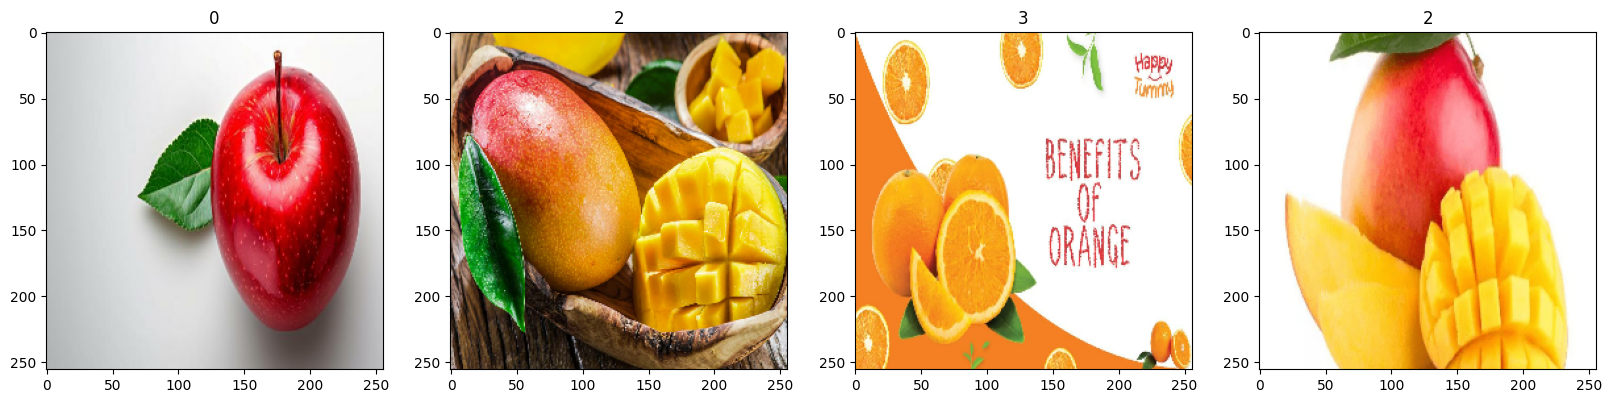

In [128]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [129]:
data = data.map(lambda x,y: (x/255, y))

In [130]:
data.as_numpy_iterator().next()

(array([[[[6.96887910e-01, 7.24338889e-01, 7.60061920e-01],
          [7.22610295e-01, 7.36979187e-01, 7.69638479e-01],
          [7.32536793e-01, 7.44301498e-01, 7.79595613e-01],
          ...,
          [7.13296592e-01, 7.31648266e-01, 7.73897052e-01],
          [7.32046545e-01, 7.47732818e-01, 7.90870070e-01],
          [7.11397052e-01, 7.27083325e-01, 7.70220578e-01]],
 
         [[7.28799045e-01, 7.48629451e-01, 7.78684616e-01],
          [7.55447209e-01, 7.66182721e-01, 7.90569961e-01],
          [7.49295831e-01, 7.58690953e-01, 7.84855127e-01],
          ...,
          [7.23468125e-01, 7.41819859e-01, 7.84068644e-01],
          [7.32046545e-01, 7.47732818e-01, 7.90870070e-01],
          [6.99150324e-01, 7.26601303e-01, 7.65816987e-01]],
 
         [[7.76157498e-01, 7.87990212e-01, 8.07686627e-01],
          [7.94495821e-01, 7.98498750e-01, 8.14246297e-01],
          [7.71031022e-01, 7.76729584e-01, 7.98114359e-01],
          ...,
          [7.26732433e-01, 7.45084167e-01, 7.8733

# 5. Split Data

In [131]:
def one_hot_encode(image, label):
    label = tf.one_hot(label, depth=4)
    return image, label

In [132]:
data = data.map(one_hot_encode)

In [133]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [134]:
train_size

9

In [135]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [136]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

In [137]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [138]:
model = Sequential()

In [139]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(4, activation='softmax'))

In [140]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [141]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)                   │ (None, 254, 254, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 127, 127, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 125, 125, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 60, 60, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 30, 30, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 14400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │       3,686,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,697,396 (14.10 MB)

 Trainable params: 3,697,396 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

# 7. Train

In [142]:
logdir='logs'

In [143]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [144]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 778ms/step - accuracy: 0.2879 - loss: 2.0007 - val_accuracy: 0.5625 - val_loss: 1.2862
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 927ms/step - accuracy: 0.3826 - loss: 1.3485 - val_accuracy: 0.4844 - val_loss: 1.1525
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 925ms/step - accuracy: 0.3739 - loss: 1.2165 - val_accuracy: 0.5000 - val_loss: 1.0821
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 986ms/step - accuracy: 0.4274 - loss: 1.1290 - val_accuracy: 0.6094 - val_loss: 0.9815
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 969ms/step - accuracy: 0.6935 - loss: 0.8614 - val_accuracy: 0.7188 - val_loss: 0.7388
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 915ms/step - accuracy: 0.7416 - loss: 0.7510 - val_accuracy: 0.7969 - val_loss: 0.5955
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 787ms/step - accuracy: 0.7338 - loss: 0.6313 - val_accuracy: 0.7812 - val_loss: 0.6011
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 848ms/step - accuracy: 0.8130 - loss: 0.5590 - val_accuracy: 0.7812 - val_loss

# 8. Plot Performance

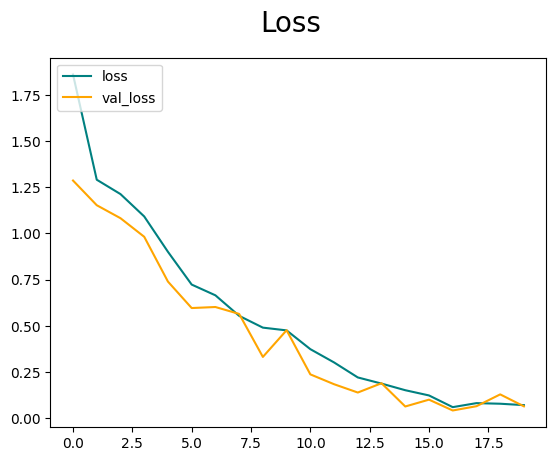

In [147]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

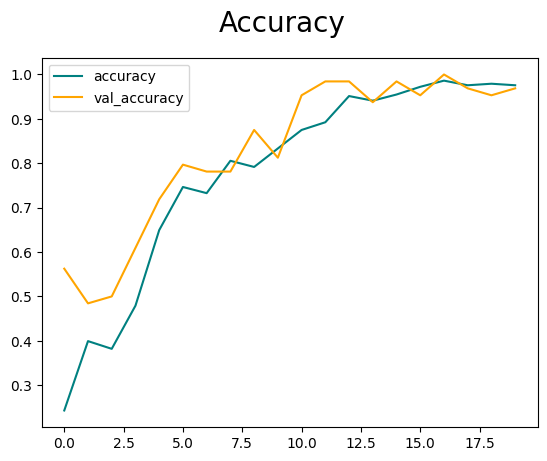

In [148]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [153]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [154]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [155]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


In [156]:
print(f'Precision: {pre.result().numpy()}, Recall: { re.result().numpy()}, Accuracy: {acc.result().numpy()}')

Precision: 0.96875, Recall: 0.96875, Accuracy: 0.96875


# 10. Test

In [157]:
import cv2

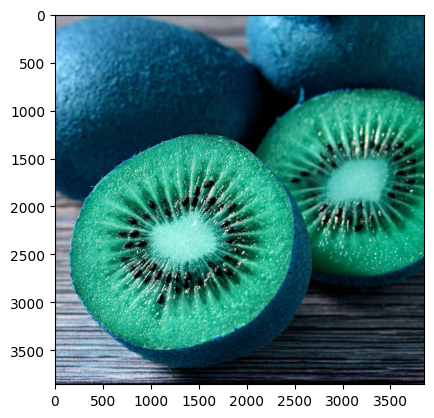

In [158]:
img = cv2.imread('kiwi-aedbdbf.jpg')
plt.imshow(img)
plt.show()

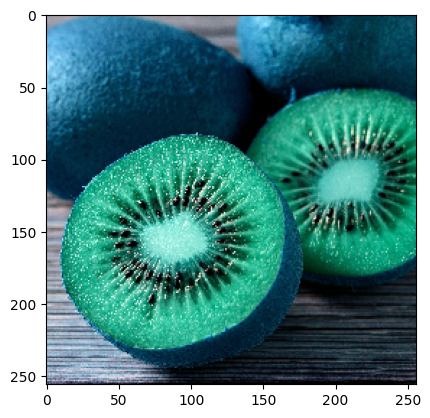

In [159]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [160]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


In [161]:
predicted_class = np.argmax(yhat)

In [162]:
print(f'Predicted class is {categories[predicted_class]}')

Predicted class is Kiwi


# 11. Save the Model

In [163]:
from tensorflow.keras.models import load_model

In [164]:
model.save(os.path.join('models','imageclassifier.h5'))

In [165]:
new_model = load_model(os.path.join('models', 'imageclassifier.h5'))

In [166]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


array([[0.01956807, 0.8955096 , 0.07347457, 0.01144775]], dtype=float32)